# Creating a New Thorn, Part 3

**Exercise:**

Make a copy of both "CreatingANewThorn" notebooks and edit them to create another new thorn, "LaplacianEta" which computes the Laplacian of the eta variable, which is a measure of the displacement of the surface of the water from rest. Like the "Energy" thorn, this quantity will be computed at analysis time.

The second derivative of a quantity is approximated by the finite difference formula:

$f''[x] = (f[x+dx] - 2 f[x] + f[x-dx])/dx^2 \approx ((f[x]+dx f'[x]+\frac{1}{2}dx^2 f[x]+...) - 2 f[x] + (f[x]-dx f'[x]+\frac{1}{2}dx^2 f[x]+...))/dx^2$

In terms of Cactus, f[x] and f[x+dx] might look something like this...
<pre>
  int cc = CCTK_GFINDEX3D(cctkGH,i,j,k)
  int cp1 = CCTK_GFINDEX3D(cctkGH,i+1,j,k)
  CCTK_REAL fx = f[cc]; // If this is f[x]
  CCTK_REAL fx1 = f[cp1]; // this is f[x+dx]
</pre>

Cactus provides an additional array of integers, like cctk_lsh, called cctk_delta_space, which provides the quantities dx, dy, and dz (these are cctk_delta_space[0], cctk_delta_space[1] and cctk_delta_space[2], respectively).

Because this is a 2-d code, the Laplacian is

$\Delta^2 \eta = \left( \frac{d^2}{dx^2} + \frac{d^2}{dy^2} \right) \eta$

Note that you will not be able to calculate the value of the Laplacian at the borders of the grid, as that would result in a segfault. Please write zeroes in the borders instead.

Note also that Funwave defines grid variables dx and dy. You can use dx[cc] (where cc = CCTK_GFINDEX3D(cctkGH,i,j,k)) in place of cctk_delta_space[0] if you want to. You CANNOT, however, redefine dx or dy.

### 1. Create empty thorn, boilerplate code

In [1]:
funwave_dir = '/home/ejwest/ETK/CactusFW2'
sim_dir = '/home/ejwest/ETK/simulations'
thorn_dir='/home/ejwest/ETK/CactusFW2/arrangements/FunwaveUtils/LaplacianEta'
%cd {funwave_dir}

/home/ejwest/ETK/CactusFW2


In [2]:
# Define some basic parameters describing a new thorn
thorn_pars = {
   "thorn_name" : "LaplacianEta",
   "arrangement_name" : "FunwaveUtils",
   "author" : "Eric West",
   "email" : "ewest@d.umn.edu",
   "license" : "BSD"
 }
import os
os.environ["ARR"]=thorn_pars["arrangement_name"]
os.environ["THORN"]=thorn_pars["thorn_name"]

In [3]:
import re
# This function does substitutes all occurances of "{name}" in input_str with values["name"]
# and returns the new string.
def replace_values(input_str,values):
    while True:
        g = re.search(r'{(\w+)}',input_str)
        if g:
            var = g.group(1)
            if var in values:
                val = values[var]
            else:
                raise Exception("Undefined: <<"+var+">>")
            start = g.start(0)
            end = start+len(g.group(0))
            input_str = input_str[0:start]+val+input_str[end:]
            continue
        break
    return input_str

# Createas a file with the given name, uses replace_values()
# to update file_contents with file_values, and writes it out.
def create_file(file_name,file_contents,file_values):
    fd = open(file_name,"w")
    file_contents = replace_values(file_contents,file_values)
    print("Over-writing file '"+file_name+"'")
    file_contents = re.sub(r'^\s+','',file_contents)
    fd.write(file_contents)
    fd.close()
    
# The equivalent of mkdir -p
def create_dir(dir):
    print("Ensuring directory '"+dir+"'")
    if not os.path.exists(dir):
        os.makedirs(dir)

In [4]:
interface_ccl_contents = """
## Interface definitions for thorn {thorn_name}
inherits:
## An implementation name is required for all thorns. No
## two thorns in a configuration can implement the same
## interface.
implements: {thorn_name}

## the groups declared below can be public, private, or protected.
public:

## A group defines a set of variables that are allocated together
## and share common properties, i.e. timelevels, tags such as the
## Prolongation=None tag. The type tag can take on the values
## GF, Scalar, or Array.

## Note that the number of timelevels can be an integer parameter
## GF stands for "Grid Function" and refers to a distributed array
## data structure.
#cctk_real force_group type=GF timelevels=3 tags='Prolongation="None"'
#{
#  force1, force2
#}

## Scalars are single variables that are available on all processors.
#cctk_real scalar_group type=SCALAR 
#{
#  scalar1, scalar2
#}
"""

In [5]:
schedule_ccl_contents = """
## Schedule definitions for thorn {thorn_name}

## There won't be any storage allocated for a group
## unless a corresponding storage declaration exists
## for it in the schedule file. In square brackets,
## we specify the number of storage levels to allocate.
## These commented examples correspond to the commented
## examples in the interface file above.
# storage: force_group[3]
# storage: scalar_group

## Schedule a function defined in this thorn to run at the beginning
## of the simulation. The minimum you need to specify for a schedule
## item is what language it's written in. Choices are: C (which includes
## C++) and Fortran (which means Fortran90).
#SCHEDULE init_function at CCTK_INIT
#{
#  LANG: C
#}"Do some initial stuff"
"""

In [6]:
param_ccl_contents = """
## Parameter definitions for thorn {thorn_name}
## There are five types of parameters: int, real, keyword, string, and boolean.
## The comments provide prototypes of each.
#
#CCTK_INT one_to_five "This integer parameter goes from 1 to 5"
#{
#  1:5 :: "Another comment"
#} 3 # This is the default value
#
#CCTK_REAL from_2p5_to_3p8e4 "This integer parameter goes from 2.5 to 3.8e4"
#{
#  2.5:3.8e4 :: "Another comment"
#} 4.4e3 # This is the default value
#
## This keyword example defines the parameter wavemaker_type and 8 possible values.
#CCTK_KEYWORD wavemaker_type "types of wave makers"
#{
#  "ini_rec" :: "initial rectangular hump, need xc,yc and wid"
#  "lef_sol" :: "initial solitary wave, WKN B solution, need amp, dep"
#  "ini_oth" :: "other initial distribution specified by users"
#  "wk_reg" :: "Wei and Kirby 1999 internal wave maker, need xc_wk, tperiod, amp_wk, dep_wk, theta_wk, and time_ramp (factor of period)"
#  "wk_irr" :: "Wei and Kirby 1999 TMA spectrum wavemaker, need xc_wk, dep_wk, time_ramp, delta_wk, freqpeak, freqmin, freqmax, hmo, gammatma, theta-peak"
#  "wk_time_series" :: "fft a time series to get each wave component and then use Wei and Kirby's ( 1999) wavemaker. Need input wavecompfile (including 3 columns:   per,amp,pha) and numwavecomp, peakperiod, dep_wk, xc_wk, ywidth_wk"
#  "ini_gau" :: "initial Gaussian hump, need amp, xc, yc, and wid"
#  "ini_sol" :: "initial solitary wave, xwavemaker"
#}"wk_reg" # This is the default value
#
#CCTK_STRING a_string_par "a comment"
#{
#  .* :: "This is a perl 5 regular expression defining what the string may contain"
#} "blah blah blah" # This is the default value
#
#BOOLEAN a_boolean_par "a comment"
#{
#} true


"""

In [7]:
configuration_ccl_contents = """
# Configuration definitions for thorn {thorn_name}
## You should not need include "mpi.h", but if you
## do, you will need this next line.
# REQUIRES MPI
# REQUIRES HDF5
"""

In [8]:
makefile_contents = """
# Main make.code.defn file for thorn {thorn_name}

# Source files in this directory
SRCS =

# Subdirectories containing source files
SUBDIRS =
"""

In [9]:
readme_contents = """
Author(s)    : {author} <{email}>
Maintainer(s): {author} <{email}>
Licence      : {license}
--------------------------------------------------------------------------

1. Purpose

not documented
"""

In [10]:
import os

# This function will create a complete thorn
def create_thorn():
  # Create the thorn directory inside the Cactus source tree
  arrangement_dir = "arrangements/"+thorn_pars["arrangement_name"]
  thorn_dir = arrangement_dir + "/" + thorn_pars["thorn_name"]
  create_dir(thorn_dir)

  # Create basic ccl files needed by Cactus
  schedule_ccl = thorn_dir+"/schedule.ccl"
  interface_ccl = thorn_dir+"/interface.ccl"
  param_ccl = thorn_dir+"/param.ccl"
  configuration_ccl = thorn_dir+"/configuration.ccl"
  create_file(schedule_ccl,schedule_ccl_contents,thorn_pars)
  create_file(interface_ccl,interface_ccl_contents,thorn_pars)
  create_file(param_ccl,param_ccl_contents,thorn_pars)
  create_file(configuration_ccl,configuration_ccl_contents,thorn_pars)

  # Create the source directory and first makefile
  src_dir = thorn_dir+"/src"
  create_dir(src_dir)
  create_file(src_dir+"/make.code.defn",makefile_contents,thorn_pars)

  # Other dirs and files not strictly needed
  # for compiling and running Cactus.
  create_file(thorn_dir+"/README",readme_contents,thorn_pars)
  
  test_dir = thorn_dir+"/test"
  create_dir(test_dir)
  par_dir = thorn_dir+"/par"
  create_dir(par_dir)
  doc_dir = thorn_dir+"/doc"
  create_dir(doc_dir)

In [11]:
create_thorn()

Ensuring directory 'arrangements/FunwaveUtils/LaplacianEta'
Over-writing file 'arrangements/FunwaveUtils/LaplacianEta/schedule.ccl'
Over-writing file 'arrangements/FunwaveUtils/LaplacianEta/interface.ccl'
Over-writing file 'arrangements/FunwaveUtils/LaplacianEta/param.ccl'
Over-writing file 'arrangements/FunwaveUtils/LaplacianEta/configuration.ccl'
Ensuring directory 'arrangements/FunwaveUtils/LaplacianEta/src'
Over-writing file 'arrangements/FunwaveUtils/LaplacianEta/src/make.code.defn'
Over-writing file 'arrangements/FunwaveUtils/LaplacianEta/README'
Ensuring directory 'arrangements/FunwaveUtils/LaplacianEta/test'
Ensuring directory 'arrangements/FunwaveUtils/LaplacianEta/par'
Ensuring directory 'arrangements/FunwaveUtils/LaplacianEta/doc'


### 2. Update thornlist

In [12]:
my_thorns_contents="""
# ./configs/sim/ThornList
# This file was automatically generated using the GetComponents script.

!CRL_VERSION = 2.0


# Component list: funwave.th

!DEFINE ROOT = CactusFW2
!DEFINE ARR = $ROOT/arrangements
!DEFINE ET_RELEASE = trunk
!DEFINE FW_RELEASE = FW_2014_05

#Cactus Flesh
!TARGET   = $ROOT
!TYPE     = git
!URL      = https://bitbucket.org/cactuscode/cactus.git
!NAME     = flesh
!CHECKOUT = CONTRIBUTORS COPYRIGHT doc lib Makefile src

!TARGET   = $ARR
!TYPE     = git
!URL      = https://bitbucket.org/stevenrbrandt/cajunwave.git
!REPO_PATH= $2
# Old version
#!AUTH_URL = https://svn.cct.lsu.edu/repos/projects/ngchc/code/branches/$FW_RELEASE/$1/$2
#!URL = https://svn.cct.lsu.edu/repos/projects/ngchc/code/branches/$FW_RELEASE/$2
#!URL = https://svn.cct.lsu.edu/repos/projects/ngchc/code/CactusCoastal/$2
!CHECKOUT =
CactusCoastal/Funwave
CactusCoastal/FunwaveMesh
CactusCoastal/FunwaveCoord
CactusCoastal/Tridiagonal
CactusCoastal/Tridiagonal2

# CactusBase thorns
!TARGET   = $ARR
!TYPE     = git
!URL      = https://bitbucket.org/cactuscode/cactusbase.git
!REPO_PATH= $2
!CHECKOUT =
CactusBase/Boundary
CactusBase/CartGrid3D
CactusBase/CoordBase
CactusBase/Fortran
CactusBase/InitBase
CactusBase/IOASCII
CactusBase/IOBasic
CactusBase/IOUtil
CactusBase/SymBase
CactusBase/Time
#
# CactusNumerical thorns
!TARGET   = $ARR
!TYPE     = git
!URL      = https://bitbucket.org/cactuscode/cactusnumerical.git
!REPO_PATH= $2
!CHECKOUT =
!CHECKOUT =
CactusNumerical/MoL
CactusNumerical/LocalInterp

CactusNumerical/Dissipation
CactusNumerical/SpaceMask
CactusNumerical/SphericalSurface
CactusNumerical/LocalReduce
CactusNumerical/InterpToArray

!TARGET   = $ARR
!TYPE     = git
!URL      = https://bitbucket.org/cactuscode/cactusutils.git
!REPO_PATH= $2
!CHECKOUT = CactusUtils/Accelerator CactusUtils/OpenCLRunTime
CactusUtils/NaNChecker
CactusUtils/Vectors
CactusUtils/SystemTopology

# Carpet, the AMR driver
!TARGET   = $ARR
!TYPE     = git
!URL      = https://bitbucket.org/eschnett/carpet.git
!REPO_PATH= $2
!CHECKOUT = Carpet/doc
Carpet/Carpet
Carpet/CarpetEvolutionMask
Carpet/CarpetIOASCII
Carpet/CarpetIOBasic
Carpet/CarpetIOHDF5
Carpet/CarpetIOScalar
#Carpet/CarpetIntegrateTest
Carpet/CarpetInterp
Carpet/CarpetInterp2
Carpet/CarpetLib
Carpet/CarpetMask
#Carpet/CarpetProlongateTest
Carpet/CarpetReduce
Carpet/CarpetRegrid
Carpet/CarpetRegrid2
#Carpet/CarpetRegridTest
Carpet/CarpetSlab
Carpet/CarpetTracker
Carpet/CycleClock
#Carpet/HighOrderWaveTest
Carpet/LoopControl
#Carpet/ReductionTest
#Carpet/ReductionTest2
#Carpet/ReductionTest3
#Carpet/RegridSyncTest
Carpet/TestCarpetGridInfo
Carpet/TestLoopControl
Carpet/Timers

# Additional Cactus thorns
!TARGET   = $ARR
!TYPE     = svn
!URL      = https://svn.cactuscode.org/projects/$1/$2/trunk
!CHECKOUT = ExternalLibraries/OpenBLAS ExternalLibraries/OpenCL ExternalLibraries/pciutils ExternalLibraries/PETSc
ExternalLibraries/MPI
ExternalLibraries/HDF5
ExternalLibraries/zlib
ExternalLibraries/hwloc

# Simulation Factory
!TARGET   = $ROOT/simfactory
!TYPE     = git
!URL      = https://bitbucket.org/simfactory/simfactory2.git
!NAME     = simfactory2
!CHECKOUT = README.md README_FIRST.txt bin doc etc lib mdb

# Various thorns from LSU
#!TARGET   = $ARR
#!TYPE     = git
#!URL      = https://bitbucket.org/einsteintoolkit/archivedthorns-vectors.git
#!REPO_PATH= $2
#!CHECKOUT =
#LSUThorns/Vectors
#LSUThorns/QuasiLocalMeasures
#LSUThorns/SummationByParts
#LSUThorns/Prolong

#Roland/MapPoints
#Tutorial/BadWaveMoL
#Tutorial/BasicWave
#Tutorial/BasicWave2
#Tutorial/BasicWave3

# Various thorns from the AEI
# Numerical
!TARGET   = $ARR
!TYPE     = git
!URL      = https://bitbucket.org/cactuscode/numerical.git
!REPO_PATH= $2
!CHECKOUT =
#AEIThorns/ADMMass
AEIThorns/AEILocalInterp
#AEIThorns/PunctureTracker
#AEIThorns/SystemStatistics
#AEIThorns/Trigger
{arrangement_name}/{thorn_name}"""
%mkdir -p thornlists
create_file("thornlists/my_thorns_laplacian.th", my_thorns_contents, thorn_pars)

Over-writing file 'thornlists/my_thorns_laplacian.th'


Compile...

In [13]:
!time ./simfactory/bin/sim build -j 2 --thornlist=thornlists/my_thorns_laplacian.th

Using configuration: sim
Updated thorn list for configuration sim
Building sim
Cactus - version: 4.2.3
Building configuration sim
Reconfiguring thorns
Reading ThornList...
Parsing configuration files...
   Boundary
           Provides:          Boundary 
   Cactus
           Optional:          MPI 
   Carpet
           Provides:          Carpet 
           Requires:          CarpetLib IOUtil MPI Timers 
           Optional:          LoopControl 
   CarpetEvolutionMask
           Requires:          Carpet 
   CarpetIOASCII
           Requires:          Carpet CarpetLib IOUtil 
           Optional:          SDF 
   CarpetIOBasic
           Requires:          Carpet CarpetLib IOUtil 
   CarpetIOHDF5
           Provides:          CarpetIOHDF5 
           Requires:          Carpet CarpetLib IOUtil HDF5 
           Optional:          MPI 
   CarpetIOScalar
           Requires:          Carpet CarpetLib IOUtil 
   CarpetInterp
           Requires:          Carpet CarpetLib MPI 
   CarpetInter

   AEILocalInterp
          0 Global, 0 Restricted, 1 Private parameters
   Boundary
          0 Global, 8 Restricted, 0 Private parameters
   Cactus
          0 Global, 6 Restricted, 13 Private parameters
   Carpet
          0 Global, 4 Restricted, 94 Private parameters
   CarpetEvolutionMask
          0 Global, 0 Restricted, 6 Private parameters
   CarpetIOASCII
          0 Global, 0 Restricted, 63 Private parameters
   CarpetIOBasic
          0 Global, 0 Restricted, 15 Private parameters
   CarpetIOHDF5
          0 Global, 0 Restricted, 77 Private parameters
   CarpetIOScalar
          0 Global, 0 Restricted, 9 Private parameters
   CarpetInterp
          0 Global, 0 Restricted, 5 Private parameters
   CarpetInterp2
          0 Global, 0 Restricted, 3 Private parameters
   CarpetLib
          0 Global, 5 Restricted, 31 Private parameters
   CarpetMask
          0 Global, 0 Restricted, 8 Private parameters
   CarpetReduce
          0 Global, 0 Restricted, 3 Private parameters
   Carp

Checking status of thorn CarpetIOBasic
Checking status of thorn HDF5
Checking status of thorn CarpetIOHDF5
Checking status of thorn CarpetIOScalar
Checking status of thorn CarpetInterp
Checking status of thorn CarpetInterp2
Checking status of thorn CarpetMask
Checking status of thorn CarpetReduce
Checking status of thorn CarpetRegrid
Checking status of thorn CarpetRegrid2
Checking status of thorn CarpetSlab
Checking status of thorn CarpetTracker
Checking status of thorn CoordBase
Checking status of thorn CartGrid3D
Checking status of thorn SphericalSurface
Checking status of thorn Dissipation
Checking status of thorn Fortran
Checking status of thorn Funwave
Checking status of thorn FunwaveCoord
Checking status of thorn FunwaveMesh
Checking status of thorn IOASCII
Checking status of thorn IOBasic
Checking status of thorn InitBase
Checking status of thorn InterpToArray
Checking status of thorn LaplacianEta
COMPILING configs/sim/bindings/build/LaplacianEta/cctk_ThornBindings.c
Updating /h

### 3. Write new thorn

Write new thorn source code...

In [14]:
%%writefile {thorn_dir}/src/laplacianEta.cc
// We pretty much always want to include these 3 headers
#include <cctk.h>
#include <cctk_Arguments.h>
#include <cctk_Parameters.h>

void compute_laplacian(CCTK_ARGUMENTS) // Cactus functions always have this prototype
{
    DECLARE_CCTK_ARGUMENTS; // Declare all grid functions (from interface.ccl)
    DECLARE_CCTK_PARAMETERS; // Declare all parameters (from param.ccl)
    
    // Note that even though this is really a 2-d calculation, Cactus
    // thinks of it as 3-d with 1 zone in the z direction.
    for(int k=0;k<cctk_lsh[2];k++) // loop over the z direction
    {   
        for(int j=0;j<cctk_lsh[1];j++) // loop over the y direction
        {
            for(int i=0;i<cctk_lsh[0];i++) // loop over the x direction
            {
                int cc = CCTK_GFINDEX3D(cctkGH,i,j,k);
                int cc_x_p1 = CCTK_GFINDEX3D(cctkGH,i+1,j,k);
                int cc_x_m1 = CCTK_GFINDEX3D(cctkGH,i-1,j,k);
                int cc_y_p1 = CCTK_GFINDEX3D(cctkGH,i,j+1,k);
                int cc_y_m1 = CCTK_GFINDEX3D(cctkGH,i,j-1,k);
                if ((i==0) || (j==0) || (i==cctk_lsh[0]) || (j==cctk_lsh[1]))
                    laplacianEta[cc] = 0;
                else
                    laplacianEta[cc] = (eta[cc_x_p1] - 2*eta[cc] + eta[cc_x_m1])/(dx[cc]*dx[cc]) \
                                     + (eta[cc_y_p1] - 2*eta[cc] + eta[cc_y_m1])/(dy[cc]*dy[cc]) ;
            }
        }
    }
}

Overwriting /home/ejwest/ETK/CactusFW2/arrangements/FunwaveUtils/LaplacianEta/src/laplacianEta.cc


Update the makefile...

In [15]:
%%writefile {thorn_dir}/src/make.code.defn
# Main make.code.defn file for thorn LaplacianEta

# Source files in this directory
SRCS = laplacianEta.cc

# Subdirectories containing source files
SUBDIRS =


Overwriting /home/ejwest/ETK/CactusFW2/arrangements/FunwaveUtils/LaplacianEta/src/make.code.defn


Update the interface file...

In [16]:
%%writefile {thorn_dir}/interface.ccl
## Interface definitions for thorn LaplacianEta
inherits: Funwave
## An implementation name is required for all thorns. No
## two thorns in a configuration can implement the same
## interface.
implements: LaplacianEta

## the groups declared below can be public, private, or protected.
public:

## A group defines a set of variables that are allocated together
## and share common properties, i.e. timelevels, tags such as the
## Prolongation=None tag. The type tag can take on the values
## GF, Scalar, or Array.

## Note that the number of timelevels can be an integer parameter
## GF stands for "Grid Function" and refers to a distributed array
## data structure.
#cctk_real force_group type=GF timelevels=3 tags='Prolongation="None"'
#{
#  force1, force2
#}

cctk_real laplacian_group type=GF
{
    laplacianEta
}

## Scalars are single variables that are available on all processors.
#{
#  scalar1, scalar2
#}


Overwriting /home/ejwest/ETK/CactusFW2/arrangements/FunwaveUtils/LaplacianEta/interface.ccl


Update schedule file...

In [17]:
%%writefile {thorn_dir}/schedule.ccl
## Schedule definitions for thorn LaplacianEta

storage: LaplacianEta::laplacian_group

## There won't be any storage allocated for a group
## unless a corresponding storage declaration exists
## for it in the schedule file. In square brackets,
## we specify the number of storage levels to allocate.
## These commented examples correspond to the commented
## examples in the interface file above.
# storage: force_group[3]
# storage: scalar_group

## Schedule a function defined in this thorn to run at the beginning
## of the simulation. The minimum you need to specify for a schedule
## item is what language it's written in. Choices are: C (which includes
## C++) and Fortran (which means Fortran90).
#SCHEDULE init_function at CCTK_INIT
#{
#  LANG: C
#}"Do some initial stuff"

schedule compute_laplacian in CCTK_ANALYSIS
{
    LANG: C
} "Compute the Laplacian for Analysis" # This comment is required!

Overwriting /home/ejwest/ETK/CactusFW2/arrangements/FunwaveUtils/LaplacianEta/schedule.ccl


Recompile...

In [18]:
%cd {funwave_dir}
!time ./simfactory/bin/sim build -j2 --thornlist=thornlists/my_thorns_laplacian.th

/home/ejwest/ETK/CactusFW2
Using configuration: sim
Updated thorn list for configuration sim
Building sim
Cactus - version: 4.2.3
Building configuration sim
Reconfiguring thorns
Reading ThornList...
Parsing configuration files...
   Boundary
           Provides:          Boundary 
   Cactus
           Optional:          MPI 
   Carpet
           Provides:          Carpet 
           Requires:          CarpetLib IOUtil MPI Timers 
           Optional:          LoopControl 
   CarpetEvolutionMask
           Requires:          Carpet 
   CarpetIOASCII
           Requires:          Carpet CarpetLib IOUtil 
           Optional:          SDF 
   CarpetIOBasic
           Requires:          Carpet CarpetLib IOUtil 
   CarpetIOHDF5
           Provides:          CarpetIOHDF5 
           Requires:          Carpet CarpetLib IOUtil HDF5 
           Optional:          MPI 
   CarpetIOScalar
           Requires:          Carpet CarpetLib IOUtil 
   CarpetInterp
           Requires:          Carpet Ca

           Implements: SphericalSurface
           Inherits:  grid 
           9 Public, 0 Protected, 1 Private variable groups
   SymBase
           Implements: SymBase
           0 Public, 0 Protected, 0 Private variable groups
   SystemTopology
           Implements: SystemTopology
           0 Public, 0 Protected, 0 Private variable groups
   TestCarpetGridInfo
           Implements: TestCarpetGridInfo
           0 Public, 0 Protected, 0 Private variable groups
   TestLoopControl
           Implements: TestLoopControl
           Inherits:  grid 
           0 Public, 0 Protected, 3 Private variable groups
   Time
           Implements: time
           1 Public, 0 Protected, 1 Private variable groups
   Timers
           Implements: Timers
           0 Public, 0 Protected, 0 Private variable groups
   Tridiagonal
           Implements: tridiagonal
           Inherits:  grid 
           2 Public, 0 Protected, 4 Private variable groups
   Tridiagonal2
           Implements: tridiagonal

Found hwloc in NO_BUILD
Finished running configuration script for thorn HWLOC.

********************************************************************************
Running configuration script for thorn MPI:
MPI selected, but MPI_DIR is not set. Computing settings...
Found MPI compiler wrapper at /usr/bin/mpic++!
Successfully configured MPI.
Finished running configuration script for thorn MPI.

********************************************************************************
Running configuration script for thorn HDF5:
Additional requested language support:  Fortran
HDF5 selected, but HDF5_DIR not set. Checking pkg-config ...
HDF5 found: /usr
Finished running configuration script for thorn HDF5.
Checking consistency...
Creating Thorn-Flesh bindings...
   Creating implementation bindings...
   Creating parameter bindings...
   Creating variable bindings...
   Creating schedule bindings...
   Creating function bindings...
CST finished.
Checking status of thorn AEILocalInterp
Checking status 

### 4. Run

Edit parfile...

In [19]:
%%writefile {funwave_dir}/par/funwave3.par

#Reorder the parameters for easy comparison to the input.txt in example 3
ActiveThorns = "
  CoordBase FunWave FunwaveCoord CartGrid3D Carpet CarpetIOASCII
  CartGrid3D IOUtil CarpetIOBasic CarpetSlab Boundary SymBase MoL
  CarpetReduce LocalReduce InitBase CarpetLib LoopControl Tridiagonal
  CarpetIOScalar LaplacianEta "

#----------------------------------------------------
# Flesh and CCTK parameters
#----------------------------------------------------

# flesh
Cactus::cctk_run_title = "Test Run"
Cactus::cctk_show_schedule = "yes"
Cactus::cctk_itlast = 300
Cactus::allow_mixeddim_gfs = "yes"

# CartGrid3D
CartGrid3D::type = "coordbase"
CartGrid3D::avoid_origin = "no"
CoordBase::domainsize = "minmax"
CoordBase::spacing    = "gridspacing"
CoordBase::xmin =  0
CoordBase::xmax =  30
CoordBase::ymin =  0
CoordBase::ymax =  30
CoordBase::zmin =  0.0
CoordBase::zmax =  0.0
CoordBase::dx   =  0.25
CoordBase::dy   =  0.25

CoordBase::boundary_size_x_lower     = 3
CoordBase::boundary_size_x_upper     = 3
CoordBase::boundary_size_y_lower     = 3
CoordBase::boundary_size_y_upper     = 3
CoordBase::boundary_size_z_lower     = 0
CoordBase::boundary_size_z_upper     = 0
CoordBase::boundary_shiftout_x_lower = 1
CoordBase::boundary_shiftout_x_upper = 1
CoordBase::boundary_shiftout_y_lower = 1
CoordBase::boundary_shiftout_y_upper = 1
CoordBase::boundary_shiftout_z_lower = 1
CoordBase::boundary_shiftout_z_upper = 1

# Carpet
Carpet::domain_from_coordbase = "yes"
Carpet::ghost_size_x = 3
Carpet::ghost_size_y = 3
Carpet::ghost_size_z = 1
carpet::adaptive_stepsize = yes

# MoL
MoL::ODE_Method = "RK3"
MoL::disable_prolongation        = "yes"

# the output dir will be named after the parameter file name
IO::out_dir = $parfile
IO::out_fileinfo="none"
IOBasic::outInfo_every = 1
IOBasic::outInfo_vars = "FunWave::eta FunWave::u FunWave::v LaplacianEta::laplacianEta"

#IOASCII::out1D_every = 1
#IOASCII::out1d_vars = "FunWave::eta Funwave::depth"
CarpetIOASCII::compact_format = false
IOASCII::out2D_every = 30
IOASCII::out2D_xyplane_z = 0
IOASCII::out2D_vars = "FunWave::eta FunWave::u FunWave::v LaplacianEta::laplacianEta"
IOASCII::out2D_xz = "no"
IOASCII::out2D_yz = "no"
IOASCII::output_ghost_points = "no"

IOScalar::outScalar_every = 1
IOScalar::outScalar_vars = "FunWave::eta FunWave::u FunWave::v LaplacianEta::laplacianEta"

#& = "Funwave::eta"

#----------------------------------------------------
# Funwave parameters
#----------------------------------------------------

# Funwave depth 
FunWave::depth_file_offset_x = 3
FunWave::depth_file_offset_y = 3
FunWave::depth_type = "flat"
FunWave::depth_format = "ele"
FunWave::depth_file = "/tmp/__depth__.txt"
FunWave::depth_flat = 0.8
#Funwave::test_depth_shore_x = 80
#Funwave::test_depth_island_x = 40
#Funwave::test_depth_island_y = 40
FunWave::depth_xslp = 10.0
FunWave::depth_slope = 0.05
FunWave::dt_size = 0
Funwave::generate_test_depth_data = true
Funwave::num_wave_components = 1
Funwave::wave_component_file = "/home/sbrandt/workspace/shi_funwave/example_2/fft/wavemk_per_amp_pha.txt"
Funwave::peak_period = 1

# import
Funwave::time_ramp = 1.0
Funwave::delta_wk = 0.5
Funwave::dep_wk = 0.45
Funwave::xc_wk = 3.0
Funwave::ywidth_wk = 10000.0
Funwave::tperiod = 1.0
Funwave::amp_wk = 0.0232
Funwave::theta_wk = 0.0
Funwave::freqpeak = 0.2
Funwave::freqmin = 0.1
Funwave::freqmax = 0.4
Funwave::hmo = 1.0
Funwave::gammatma = 5.0
Funwave::thetapeak = 10.0
Funwave::sigma_theta = 15.0

# Funwave wind forcing
Funwave::wind_force = false
Funwave::use_wind_mask = false
Funwave::num_time_wind_data = 2
Funwave::timewind[0] = 0
Funwave::wu[0] = 25
Funwave::wv[0] = 50
Funwave::timewind[1] = 1000
Funwave::wu[1] = 100
Funwave::wv[1] = 100
Funwave::boundary = funwave

# Funwave wave maker
FunWave::wavemaker_type = "ini_gau"
FunWave::xc = 26.5
FunWave::yc = 26.9
FunWave::amp =  2.0
FunWave::wid =  1
Funwave::wdep = 0.78
Funwave::xwavemaker = 25.0

# Funwave sponge 
FunWave::sponge_on = false
FunWave::sponge_west_width = 2.0
FunWave::sponge_east_width = 2.0
FunWave::sponge_north_width = 0.0
FunWave::sponge_south_width = 0.0
FunWave::sponge_decay_rate = 0.9
FunWave::sponge_damping_magnitude = 5.0

# Funwave dispersion (example 3 enables dispersion)
FunWave::dispersion_on = "true"
FunWave::gamma1 = 1.0
FunWave::gamma2 = 1.0
FunWave::gamma3 = 1.0
FunWave::beta_ref = -0.531
FunWave::swe_eta_dep = 0.80
FunWave::cd = 0.0

# Funwave numerics (MoL parameter controls time integration scheme)
FunWave::reconstruction_scheme = "fourth"
FunWave::riemann_solver = "HLLC"
FunWave::dtfac = 0.5
FunWave::froudecap = 10.0
FunWave::mindepth = 0.001
FunWave::mindepthfrc = 0.001
FunWave::enable_masks = "true"
Funwave::estimate_dt_on = "true"

FunwaveCoord::spherical_coordinates = false

ActiveThorns = "CarpetIOHDF5"
IOHDF5::out2D_xyplane_z = 0 
IOHDF5::out2D_every = 10
IOHDF5::out2D_vars = " 
  FunWave::eta
  FunWave::u
  FunWave::v
  LaplacianEta::laplacianEta
  Grid::Coordinates{out_every=1000000000}
"
IOHDF5::out2D_xz = no
IOHDF5::out2D_yz = no

Overwriting /home/ejwest/ETK/CactusFW2/par/funwave3.par


In [20]:
!rm -rf {sim_dir}/funwave3

In [21]:
%cd {funwave_dir}
!./simfactory/bin/sim create-run funwave3 --procs=2 --parfile=par/funwave3.par

/home/ejwest/ETK/CactusFW2
Parameter file: /home/ejwest/ETK/CactusFW2/par/funwave3.par
Skeleton Created
Job directory: "/home/ejwest/ETK/simulations/funwave3"
Executable: "/home/ejwest/ETK/CactusFW2/exe/cactus_sim"
Option list: "/home/ejwest/ETK/simulations/funwave3/SIMFACTORY/cfg/OptionList"
Submit script: "/home/ejwest/ETK/simulations/funwave3/SIMFACTORY/run/SubmitScript"
Run script: "/home/ejwest/ETK/simulations/funwave3/SIMFACTORY/run/RunScript"
Parameter file: "/home/ejwest/ETK/simulations/funwave3/SIMFACTORY/par/funwave3.par"
Simulation name: funwave3
Assigned restart id: 0 
Running simulation funwave3
Preparing:
+ set -e
+ cd /home/ejwest/ETK/simulations/funwave3/output-0000-active
+ echo Checking:
Checking:
+ pwd
/home/ejwest/ETK/simulations/funwave3/output-0000-active
+ hostname
newton
+ date
Sun Apr 28 22:17:52 CDT 2019
+ echo Environment:
Environment:
+ export CACTUS_NUM_PROCS=1
+ export CACTUS_NUM_THREADS=2
+ export GMON_OUT_PREFIX=gmon.out
+ export OMP_NUM_THREADS=2
+ env


INFO (CycleClock): Calibrated CycleClock: 0.303711 ns per clock tick (3.2926 GHz)
  ____       _          __        __              
 / ___|__ _ (_)_   _ _ _\ \      / /_ ___   _____ 
| |   / _` || | | | | '_ \ \ /\ / / _` \ \ / / _ \
| |__| (_| || | |_| | | | \ V  V / (_| |\ V /  __/
 \____\__,_|/ |\__,_|_| |_|\_/\_/ \__,_| \_/ \___|
          |__/                                    
INFO (Vectors): Using vector size 2 for architecture SSE2 (64-bit precision)
--------------------------------------------------------------------------------
AMR driver provided by Carpet
--------------------------------------------------------------------------------
AMR info I/O provided by CarpetIOBasic
--------------------------------------------------------------------------------
AMR 0D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------------------------------
AMR 1D ASCII I/O provided by CarpetIOASCII
--------------------------------------------------------

        3     1.048 |   -0.7827099    0.7827247 |   -0.7908120    0.7945910 | -2.204493e-13    1.7406879 |   -2.7520217    0.6847192
        4     1.071 |   -0.9871958    0.9871304 |   -1.0078458    1.0085949 | -8.400691e-14    1.5989647 |   -2.4423352    0.8368867
        5     1.094 |   -1.1744423    1.1742063 |   -1.1909363    1.1836515 | -1.710410e-15    1.4476202 |   -2.1557836    0.8348119
        6     1.117 |   -1.3292681    1.3289617 |   -1.3316063    1.3201955 | -1.152414e-14    1.2961226 |   -1.9867833    0.8413811
        7     1.140 |   -1.4464243    1.4460941 |   -1.4436961    1.4892265 | -7.675744e-14    1.1507342 |   -1.9037864    0.9321670
        8     1.162 |   -1.5469224    1.5458777 |   -1.6224632    1.6048745 | -9.317621e-16    1.0141344 |   -2.4380757    1.0606282
        9     1.185 |   -1.6090563    1.6066068 |   -1.7050094    1.6735034 | -3.912694e-15    0.8880859 |   -3.4495359    1.0608563
       10     1.208 |   -1.6386679    1.6345209 |   -1.7530102    1.7

       57     2.317 |   -1.9281143    0.2444847 |   -1.7139568    0.1615919 |   -0.3285827    0.7226012 |   -3.9252095    2.2356217
       58     2.339 |   -1.8296830    0.2295761 |   -1.8266446    0.1224592 |   -0.3246903    0.6970215 |   -3.6031350    2.4730762
       59     2.361 |   -1.9223186    0.2215102 |   -1.7805748    0.1314378 |   -0.3213394    0.6788942 |   -3.3201130    2.5767951
-----------------------------------------------------------------------------------------------------------------------------------
Iteration      Time |                FUNWAVE::u |                FUNWAVE::v |              FUNWAVE::eta | *PLACIANETA::laplacianEta
                    |      minimum      maximum |      minimum      maximum |      minimum      maximum |      minimum      maximum
-----------------------------------------------------------------------------------------------------------------------------------
       60     2.383 |   -1.8398102    0.2132160 |   -1.6908744    0.1505634 

      108     3.522 |   -1.2195789    0.1392731 |   -1.2130160    0.1380853 |   -0.2491385    0.6046090 |   -4.7957091    2.1452862
      109     3.547 |   -1.2106405    0.1394119 |   -1.2161139    0.1391630 |   -0.2563714    0.6048681 |   -4.5764382    2.0218647
      110     3.573 |   -1.2105523    0.1405991 |   -1.2088572    0.1398793 |   -0.2634204    0.5969148 |   -4.3380219    2.0283725
      111     3.599 |   -1.1996253    0.1408904 |   -1.2002563    0.1412257 |   -0.2703028    0.6002477 |   -4.5724378    2.0076413
      112     3.625 |   -1.1949366    0.1415017 |   -1.2005551    0.1469123 |   -0.2770321    0.5909917 |   -4.1073064    1.8795379
      113     3.651 |   -1.1925346    0.1426095 |   -1.1903770    0.1563096 |   -0.2836290    0.5928934 |   -4.6543378    1.9644432
      114     3.678 |   -1.1792564    0.1424504 |   -1.1865481    0.1627133 |   -0.2900687    0.5827707 |   -4.0871893    1.7501180
      115     3.704 |   -1.1790620    0.1429598 |   -1.1839734    0.1745343 

      161     4.982 |   -0.9950475    0.5143159 |   -0.9581211    0.4699518 |   -0.2250631    0.3655322 |   -1.6656228    1.0095715
      162     5.011 |   -1.0004798    0.5242588 |   -0.9556712    0.4785557 |   -0.2245745    0.3673628 |   -1.7122938    1.1131583
      163     5.039 |   -0.9928053    0.5317480 |   -0.9533465    0.4852857 |   -0.2235524    0.3643980 |   -1.5495165    1.0592893
      164     5.068 |   -1.0032191    0.5366419 |   -0.9430352    0.4900613 |   -0.2219769    0.3619333 |   -1.6257281    0.9649642
      165     5.096 |   -1.0075654    0.5388146 |   -0.9449306    0.4927810 |   -0.2197630    0.3643078 |   -1.6557436    1.0587191
      166     5.125 |   -0.9990207    0.5381897 |   -0.9402740    0.4934024 |   -0.2168776    0.3603049 |   -1.5209861    0.9950155
      167     5.153 |   -1.0040400    0.5346811 |   -0.9333726    0.4918837 |   -0.2133366    0.3587039 |   -1.5740756    0.9229052
      168     5.182 |   -1.0073972    0.5283035 |   -0.9338535    0.4881965 

      216     6.609 |   -0.7945963    0.3743043 |   -0.7729980    0.4411789 |   -0.1775975    0.3096066 |   -1.3197979    0.5225778
      217     6.640 |   -0.7895058    0.3758773 |   -0.7679038    0.4429231 |   -0.1774639    0.3070860 |   -1.2072293    0.4961925
      218     6.671 |   -0.7891180    0.3791573 |   -0.7681514    0.4459202 |   -0.1775547    0.3060241 |   -1.2896370    0.4653753
      219     6.702 |   -0.7807708    0.3818704 |   -0.7626188    0.4477128 |   -0.1777031    0.3036830 |   -1.1758650    0.4290596
-----------------------------------------------------------------------------------------------------------------------------------
Iteration      Time |                FUNWAVE::u |                FUNWAVE::v |              FUNWAVE::eta | *PLACIANETA::laplacianEta
                    |      minimum      maximum |      minimum      maximum |      minimum      maximum |      minimum      maximum
----------------------------------------------------------------------------

      267     8.237 |   -0.6776477    0.4063605 |   -0.6563925    0.4422116 |   -0.1582945    0.2236090 |   -0.6383098    0.2327171
      268     8.269 |   -0.6734256    0.4059333 |   -0.6535384    0.4421553 |   -0.1577800    0.2217224 |   -0.6467768    0.2437283
      269     8.302 |   -0.6756800    0.4045318 |   -0.6554061    0.4411120 |   -0.1571127    0.2206535 |   -0.6176059    0.2496497
      270     8.334 |   -0.6711322    0.4046642 |   -0.6501599    0.4390332 |   -0.1563702    0.2209410 |   -0.6243175    0.2518101
      271     8.367 |   -0.6710783    0.4044379 |   -0.6510131    0.4387896 |   -0.1558859    0.2205042 |   -0.6427178    0.2441884
      272     8.400 |   -0.6706263    0.4032953 |   -0.6504622    0.4380201 |   -0.1553208    0.2189918 |   -0.6102706    0.2380706
      273     8.432 |   -0.6644033    0.4028924 |   -0.6438784    0.4362545 |   -0.1545145    0.2199283 |   -0.5879317    0.2562460
      274     8.465 |   -0.6678908    0.4028691 |   -0.6477349    0.4349431 

Plot output...

In [22]:
%cd {sim_dir}/funwave3/output-0000/funwave3
%ls

/home/ejwest/ETK/simulations/funwave3/output-0000/funwave3
eta.average.asc            laplacianEta.maximum.asc   u.xy.asc
eta.count.asc              laplacianEta.minimum.asc   u.xy.h5
eta.iaverage.asc           laplacianEta.norm1.asc     v.average.asc
eta.icount.asc             laplacianEta.norm2.asc     v.count.asc
eta.inorm1.asc             laplacianEta.norm_inf.asc  v.iaverage.asc
eta.inorm2.asc             laplacianEta.sum.asc       v.icount.asc
eta.maximum.asc            laplacianEta.xy.asc        v.inorm1.asc
eta.minimum.asc            laplacianEta.xy.h5         v.inorm2.asc
eta.norm1.asc              r.xy.h5                    v.maximum.asc
eta.norm2.asc              u.average.asc              v.minimum.asc
eta.norm_inf.asc           u.count.asc                v.norm1.asc
eta.sum.asc                u.iaverage.asc             v.norm2.asc
eta.xy.asc                 u.icount.asc               v.norm_inf.asc
eta.xy.h5                  u.inorm1.asc               v.sum.asc
funwave3.pa

In [23]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


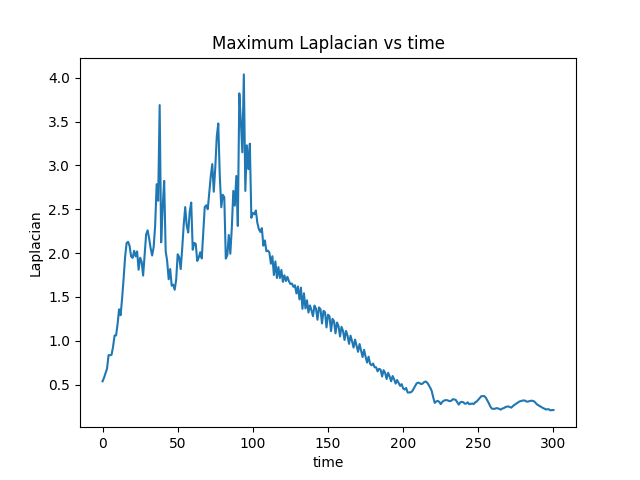

In [24]:
# plot max vs time
data = np.genfromtxt("laplacianEta.maximum.asc")
#data = np.genfromtxt("eta.maximum.asc")
plt.plot(data[:,0], data[:,2])
plt.xlabel('time')
plt.ylabel('Laplacian')
plt.title('Maximum Laplacian vs time')
plt.show()

In [25]:
# animate xy-slice using imshow()
import matplotlib.cm as cm
import matplotlib.animation as animation
file_data = np.genfromtxt("laplacianEta.xy.asc")

# figure properties
cmap = cm.gist_rainbow
fig_width = 4
fig_height = 4
minval = np.min(file_data[:,12])
maxval = np.max(file_data[:,12])

# time steps
time_steps = np.unique(file_data[:,0]) 

# extract data
def extract_data(tstep): 
    ttdata = file_data[file_data[:,0]==tstep, :] #find matching time blocks
    x = ttdata[:, 5]  #x coordinate in 5th column
    y = ttdata[:, 6]  #y coordinate in 6th column
    z = ttdata[:, 12] #data in 12th column
    zi = z.reshape(len(np.unique(y)), len(np.unique(x))) #reshape
    return zi[::-1, :]

# initialize plot
plt.ioff()
fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.add_subplot(111)
data = extract_data(time_steps[0])
plot = [ax.imshow(data, cmap=cmap, clim=(minval, maxval))]

# update plot
def update_plot(frame_number, extract_data, plot):
    plot[0].remove()
    data = extract_data(time_steps[frame_number])
    plot[0] = ax.imshow(data, cmap=cmap, clim=(minval, maxval))

# make animation
fps=3
frames=np.arange(0, len(time_steps), 1)
anim = animation.FuncAnimation(
    fig, update_plot, frames, fargs=(extract_data, plot), 
    interval=1000/fps, blit=False, repeat=False)
plt.close()

# play animation
from IPython.display import HTML
#HTML(anim.to_html5_video())
HTML(anim.to_jshtml())